In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numba import njit, prange

Model including deletion and activity penalization

In [2]:
##################### ASSING_ACTIVITY ###############################
# Assigns activities following a powerlaw distribution
@njit
def Assign_Activity(eps1, eps2, gamma):
    rand = np.random.uniform(0, 1)
    power_rand = (eps1**(1-gamma) + (eps2**(1-gamma) - eps1**(1-gamma)) * rand)**(1/(1-gamma))
    return power_rand

@njit(parallel=True)
def Probability_Distribution_Opinion(G, numb_node, T, beta, Phi):
    N = len(G)
    prob = np.zeros(N)

    distance = np.zeros(N)

    # Calculate Norm
    norm = 0
    for i in prange (N):
        if i != numb_node: 
            # numb_node is the number of the selected node
            for u in range (T):
                for v in range (T):
                    distance[i] += (G[i][u] - G[numb_node][u]) * (G[i][v] - G[numb_node][v]) * Phi[u][v]
            norm += np.sqrt(distance[i])**(-beta)
        

    # Calculate Probability of contact
    for i in prange (N): 
        if i != numb_node:
            prob[i] = (np.sqrt(distance[i])**(-beta) / norm)
    return prob

def Connect(N, m, G, G_num, T, beta, Phi):
    A = np.full((N,N), N+1)
    # Create counting array to place adjacent nodes correctly in array
    count_arr = np.zeros(N, dtype=int)

    act_count = 0

    for i in range (N):
        # Go through nodes and possibly activate them
        rand = np.random.uniform(0,1)
        if rand <= G[i][T]:
            act_count += 1
            # Pick m other nodes randomly. No exception of i needed, since
            # P_D_O excludes i already
            prob = Probability_Distribution_Opinion(G, i, T, beta, Phi)
            picks = np.random.choice(G_num, m, replace=False, p=prob)
            #Update adjacency list: append nodes j to i´s place and vice versa
            for j in picks:
                A[i][count_arr[i]] = j
                A[j][count_arr[j]] = i
                count_arr[i] += 1
                count_arr[j] += 1

    return A, act_count

@njit(parallel = True)
def ODEs_pen_act(N, T, A, G, K, alpha, Phi, current_opinions, opinions_step, model, model_params):
    # Determine social influence to return the differential. current_opinions and opinions_step
    # are arrays of the form [..., [agent_i_op1, agent_i_op2], [agent_i+1_op1, agent_i+1_op2], ...]
    influence = np.zeros((N,T))
    count = np.zeros((N,T))
    for i in prange (N):
        for o in range (T):
            # Go through connected agents of i
            if model == -1:
                while A[i][int(count[i][o])] != N+1:
                    # Cuts all social influence as test wether everything works.
                    # act is the activity of connected node j
                    act = G[A[i][int(count[i][o])]][T]
                    influence[i][o] += np.tanh(alpha * np.dot(Phi, current_opinions[A[i][int(count[i][o])]])[o]) * (0) # times zero
                    count[i][o] += 1
            if model == 0:
                while A[i][int(count[i][o])] != N+1:
                    # act is the activity of connected node j
                    act = G[A[i][int(count[i][o])]][T]
                    # Penalized term, linear in activity
                    influence[i][o] += np.tanh(alpha * np.dot(Phi, current_opinions[A[i][int(count[i][o])]])[o]) * (1 - act)
                    count[i][o] += 1
            if model == 1:
                while A[i][int(count[i][o])] != N+1:
                    # act is the activity of connected node j
                    act = G[A[i][int(count[i][o])]][T]
                     # Penalized term, 1/2 * tanh(-a*(x-b)) + 1/2
                    influence[i][o] += np.tanh(alpha * np.dot(Phi, current_opinions[A[i][int(count[i][o])]])[o]) * (0.5 * np.tanh(-model_params[0] * (act - model_params[1])) + 0.5)
                    count[i][o] += 1
            if model == 2:
                while A[i][int(count[i][o])] != N+1:
                    # act is the activity of connected node j
                    act = G[A[i][int(count[i][o])]][T]
                    # Penalized term, 1-exp(a * (x-1))
                    influence[i][o] += np.tanh(alpha * np.dot(Phi, current_opinions[A[i][int(count[i][o])]])[o]) * (1 - np.exp( model_params[0] * (act - 1) ))
                    count[i][o] += 1
            if model == 3:
                while A[i][int(count[i][o])] != N+1:
                    # act is the activity of connected node j
                    act = G[A[i][int(count[i][o])]][T]
                    # Penalized term, heaviside
                    if act <= model_params[0]:
                        influence[i][o] += np.tanh(alpha * np.dot(Phi, current_opinions[A[i][int(count[i][o])]])[o])
                    else:
                        influence[i][o] += 0
                    count[i][o] += 1


    #return differential
    dxdt = -opinions_step + K * influence
    return dxdt

#################### RK4_act_pen #############################################
# RK4 with activity penalized ODEs

@njit(parallel = True)
def RK4_act_pen(G, T, A, K, alpha, Phi, dt, model, model_params):
    N = len(G)
    # Save current opinions
    current_opinions = np.zeros((N,T))
    for i in prange (N):
        for j in range (T):
            current_opinions[i][j] += G[i][j]

    # Calculate ks
    k1 = dt * ODEs_pen_act(N, T, A, G, K, alpha, Phi, current_opinions, current_opinions, model, model_params)
    k2 = dt * ODEs_pen_act(N, T, A, G, K, alpha, Phi, current_opinions, current_opinions + 0.5 * k1, model, model_params)
    k3 = dt * ODEs_pen_act(N, T, A, G, K, alpha, Phi, current_opinions, current_opinions + 0.5 * k2, model, model_params)
    k4 = dt * ODEs_pen_act(N, T, A, G, K, alpha, Phi, current_opinions, current_opinions + k3, model, model_params)

    # Calculate total change and update opinions
    k = 1/6 * (k1 + 2*k2 + 2*k3 + k4)
    current_opinions += k
    for i in prange (N):
        for j in range (T):
            G[i][j] = current_opinions[i][j]

@njit(parallel=True)
def Deletes(G, N, thresh, frac_nodes, std, count):
    # Define array that saves number of Nodes that have an opinion distance 
    # below thresh
    close = np.zeros(N)
    # Save deleted opinions
    delops = np.zeros((N,2), dtype='float')
    # Determine how many nodes have an opinion distance below thresh
    # to each node
    for i in prange(N):
        for j in prange(N):
            # Node shouldn´t interact with itself
            if i != j:
                # Calculate distance in if-case to enable parallel-looping
                # with numba
                if (np.sqrt( (G[j][0] - G[i][0])**2 + (G[j][1] - G[i][1])**2 )) < thresh:
                    close[i] += 1

    for i in prange(N):
        if close[i] <= np.floor(frac_nodes*N):
            delops[i] = G[i,:2]
            count += 1
            # "Delete" node by resetting its opinion with random values
            G[i][0] = np.random.normal(0, np.sqrt(std))
            G[i][1] = np.random.normal(0, np.sqrt(std))
    return delops, count

def Save(save, Adj, N, T, filename):
    # Create Dataframe and convert it to .csv
    df = pd.DataFrame(save)
    df.to_csv(f"D:\Daten mit Änderungen\Physik\Bachelorarbeit\Generated_Data\Deletion\{filename}.csv", index = False, header = False)

    # Save Adjacency Matrix
    pd.DataFrame(Adj).to_csv(f"D:\Daten mit Änderungen\Physik\Bachelorarbeit\Generated_Data\Deletion\{filename}_mat.csv", index = False, header = False)

@njit(parallel = True)
def Update_Adjacency_Matrix(Adj, A, N):
    count = np.zeros(N)
    for i in range (N):
        # Again N+1 is the breaking value
        while A[i][int(count[i])] != N+1:
            con = A[i][int(count[i])]
            Adj[i][con] = 1
            Adj[con][i] = 1
            count[i] += 1





def Opinion_Dynamics(N, T, m, K, alpha, beta, gamma, Phi, eps1, eps2, runtime_net, runtime_op, dt, filename, thresh, frac_nodes, std):
    # Parameters N to eps1 are the same as in the paper introducing the model. Eps2 is the upper bound for activity,
    # runtime_net is the number of times a new AD-network is formed, runtime_op is the number of opinion-iterations
    # performed on that network. Default is runtime_op = 1. dt is the integration time-step and filename is a string
    # containing the name of the file in which the opinion dynamcis of the agents are saved (filename.csv).

    # Create array to save opinions of all agents at the beginning and the end
    save = np.zeros((2*runtime_net+1, N))
    # Create Array that contains node's activities and opinions
    G = np.zeros((N,T+1))
    # Give each array entry (node) a number, save in array G_num
    G_num = np.arange(0,N)
    # To later retrieve the integrated network over the last 70 iterations (As in the paper) create
    # an adjacency matrix
    Adj = np.zeros((N,N))
    # save # of active nodes per iteration
    acts = np.zeros(runtime_net)
    count = 0

    # Save deleted opinions
    delops = np.zeros((runtime_net, N, T), dtype='float')

    # Initialize Activity and Opinions of Nodes
    for i in range (N):
        G[i][T] = Assign_Activity(eps1, eps2, gamma)
        for j in range (T):
            G[i][j] = np.random.normal(0, np.sqrt(2.5))

    # Save activities of agents in first row of save and their opinions in the second and third row
    for i in range (N):
        save[0][i] += G[i][T]

    model = 3
    model_params = np.array([0.2])

    # Perform Iterations until runtime_net is reached
    iteration_net = 0
    while iteration_net < runtime_net:

        # Save opinions of agents
        for i in range (N):
            for j in range(T):
                # first row of save contains activities. After that for each iteration there´s a row for each iteration,
                # i.e. for two opinions two rows per iteration. 
                save[(T*iteration_net)+j+1][i] += G[i][j]

        # Form connections between Agents
        A, acts[iteration_net] = Connect(N, m, G, G_num, T, beta, Phi)
        
        # Calculate the influence of the nodes on eachother
        iteration_op = 0
        while iteration_op < runtime_op:
            # Update opinions via Runge-Kutta 4
            RK4_act_pen(G, T, A, K, alpha, Phi, dt, model, model_params)
            # increase iteration
            iteration_op += 1
        
        # Update adjacency matrix if last 70 iterations are reached
        if iteration_net >= runtime_net - 71:
            Update_Adjacency_Matrix(Adj, A, N)

        # Print progress bar
        if iteration_net % (int(runtime_net/100)) == 0:
            percent = int(100 * iteration_net/runtime_net)
            #print(percent)
            left = 40 * percent // 100
            right = 40 - left
    
            tags = "#" * left
            spaces = " " * right
            percents = f"{percent:.0f}%"
    
            print("\r[", tags, spaces, "]", percents, sep="", end="", flush=True)

        # Delete nodes that differ too much
        delops[iteration_net], count = Deletes(G, N, thresh, frac_nodes, std, count)

        iteration_net += 1

    Save(save, Adj, N, T, filename)

    act_med = 0
    for i in range (len(acts)):
        act_med += acts[i]
    act_med = act_med/runtime_net

    # Print last part of progress bar
    percents = f"{100:.0f}%"
    tags = "#" * 40
    print("\r[", tags, "]", percents, "\n", sep="", end="", flush=True)

    return delops, count

In [3]:
N = 2500 # 1000 nodes should be the minimum, below initial fluctuations take over and polarization becomes instable
T = 2
m = 10 # np.floor(N+50/100)
K = 3
alpha = 1.5
beta = 5.0
gamma = 2.1
Phi = np.array([[1.0,0.0],[0.0,1.0]])
eps1 = 0.01
eps2 = 1.0
runtime_net = 10**3 # Stability is reached from about 500 iterations
runtime_op = 1
step = 0.01
print("m: ", m)
print("Phi: ", Phi[0][0], Phi[0][1], Phi[1][0], Phi[1][1])
# File Names should be a 2-dim array with the first dimension being for each wanted value of a parameter
# and the second dimension full of array names for the multiple simulations.
thresh = [64.0, 32.0, 16.0, 8.0, 4.0]
frac_nodes = 0.5
#std = [0.1, 0.5, 1.5, 2.5]
std = [0.5]

m:  10
Phi:  1.0 0.0 0.0 1.0


In [15]:
delops = np.zeros((len(thresh), runtime_net, N, 2))
count = np.zeros(len(thresh))

for i in range(len(thresh)):
    for j in range(len(std)):
        print(f"{len(std)*i+j+1} of {len(thresh)*len(std)}")
        File_Names = [f"a{alpha}_b{beta}_thresh{thresh[i]}_frac{frac_nodes}_std{std[j]}_pen"]
        delops[i], count[i] = Opinion_Dynamics(N, T, m, K, alpha, beta, gamma, Phi, eps1, eps2, runtime_net, runtime_op, step, File_Names[0], thresh[i], frac_nodes, std[j])

1 of 5
[########################################]100%
2 of 5
[########################################]100%
3 of 5
[########################################]100%
4 of 5
[########################################]100%
5 of 5
[########################################]100%
[   0.    0.    0.  863. 6976.]


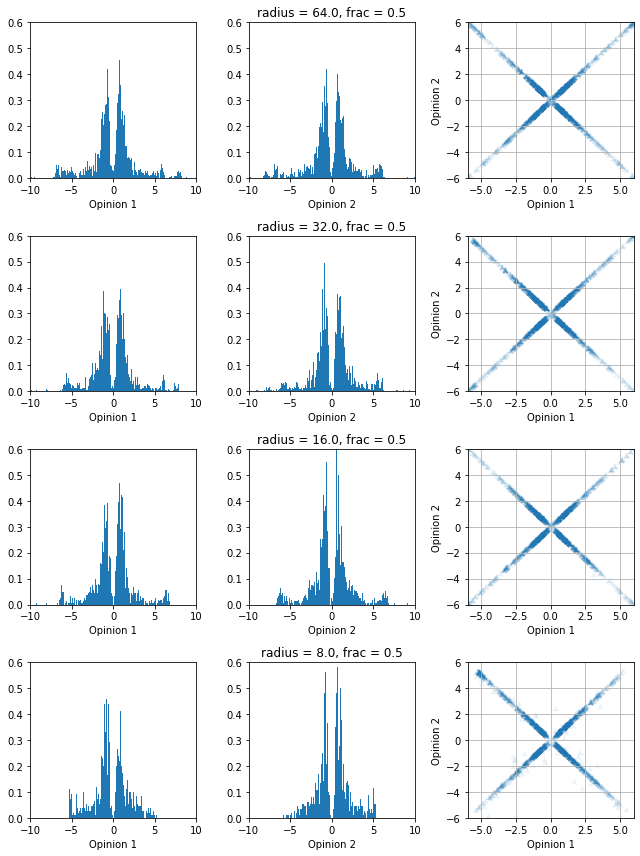

In [5]:
thresh = [64.0, 32.0, 16.0, 8.0]
alpha = 2.5
std = 0.5
frac_nodes = 0.5

inds = np.arange(0, N, 1)

num_nodes = 5
rands = np.random.choice(inds, num_nodes, replace=False)

fig, ax = plt.subplots(len(thresh),3,figsize=(3*3,len(thresh)*3))

for i in range (len(thresh)):
    df = pd.read_csv(f'D:\Daten mit Änderungen\Physik\Bachelorarbeit\Generated_Data\Deletion\\a{alpha}_b{5.0}_thresh{thresh[i]}_frac{frac_nodes}_std{std}_pen.csv', header = None)
    data = df.to_numpy()
    # ax[i][0].grid()
    # ax[i][1].grid()
    ax[i][2].grid()
    ax[i][0].hist( data[len(data)-2], density = True, bins=250 )
    ax[i][1].hist( data[len(data)-1], density = True, bins=250 )
    #ax[i][2].scatter( data[len(data)-2], data[len(data)-1], c=data[0], cmap='hot', marker = '2', alpha = 0.1 )
    ax[i][2].scatter( data[len(data)-2], data[len(data)-1], marker = '2', alpha = 0.1 )
    ax[i][1].set_title(f"radius = {thresh[i]}, frac = {frac_nodes}")
    ax[i][0].set_xlabel("Opinion 1")
    #ax[i][0].set_ylabel("Opinion Density")
    ax[i][1].set_xlabel("Opinion 2")
    #ax[i][1].set_ylabel("Opinion Density")
    ax[i][2].set_xlabel("Opinion 1")
    ax[i][2].set_ylabel("Opinion 2")
    ax[i][2].set_xlim(-6,6)
    ax[i][2].set_ylim(-6,6)
    ax[i][0].set_xlim(-10,10)
    ax[i][1].set_xlim(-10,10)
    ax[i][0].set_ylim(0,0.6)
    ax[i][1].set_ylim(0,0.6)
    # Create scatter of random nodes
    # length per opinion
    # length = int((len(data)-1)/2)
    # #print(length)
    # nodes = np.zeros((length, num_nodes, 2))
    # # Sort opinions
    # for j in range (length):
    #     for k in range (num_nodes):
    #         nodes[j][k][0] = data[2*j+1][rands[k]]
    #         nodes[j][k][1] = data[2*j+2][rands[k]]
    # for j in range(num_nodes):
    #     ax[i][3].plot( nodes[:,j,0], nodes[:,j,1], linewidth=0.5, alpha=1.0, label=f"{data[0][rands[j]]:.2f}" )
    #     ax[i][3].scatter( nodes[0,j,0], nodes[0,j,1] )
    # ax[i][3].grid()
    # ax[i][3].legend()

    
    # ax[i][0].set_xlim(-10,10)
    # ax[i][1].set_xlim(-10,10)

plt.tight_layout()
plt.savefig(f"D:/Daten mit Änderungen/Physik/Bachelorarbeit/Figures/Deletion_Pol_Pen_std{std}.png", dpi=300)